In [1]:
import os
import json
import zipfile
import shutil
import glob
import pandas as pd
import numpy as np
import cv2
import yaml
from tqdm import tqdm

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.9/614.9 kB 10.1 MB/s eta 0:00:00


In [3]:
from ultralytics import YOLO, checks, hub
checks()

Ultralytics YOLOv8.0.150 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.4/166.8 GB disk)


In [44]:
SEED = 42
BATCH_SIZE = 4
MODEL = "trained_model" # 학습한 모델에 대한 정보
EPOCH = 100

In [5]:
!unzip /content/train.zip -d train
!unzip /content/test.zip -d test
!unzip /content/val.zip -d val

Archive:  /content/train.zip
  inflating: train/syn_00000.png     
  inflating: train/syn_00500.png     
  inflating: train/syn_01000.png     
  inflating: train/syn_01500.png     
  inflating: train/syn_02000.png     
  inflating: train/syn_02500.png     
  inflating: train/syn_03000.png     
  inflating: train/syn_03500.png     
  inflating: train/syn_04000.png     
  inflating: train/syn_04500.png     
Archive:  /content/test.zip
  inflating: test/064442001.png      
  inflating: test/100522633.png      
  inflating: test/114150029.png      
  inflating: test/133342232.png      
  inflating: test/144738964.png      
Archive:  /content/val.zip
  inflating: val/syn_05000.png       
  inflating: val/syn_05500.png       
  inflating: val/syn_06000.png       


In [ ]:
# 작업한 파일 담을 폴더 생성
if os.path.exists("./data"):
    shutil.rmtree("./data")

if not os.path.exists("./data/train"):
    os.makedirs("./data/train")

if not os.path.exists("./data/val"):
    os.makedirs("./data/val")

if not os.path.exists("./data/test"):
    os.makedirs("./data/test")

if not os.path.exists("./results"):
    os.makedirs("./results")

In [10]:
# txt 파일을 욜로 학습용 txt로 변환
def make_yolo_dataset(image_paths, txt_paths, type="train"):
    for image_path, txt_path in tqdm(zip(image_paths, txt_paths if not type == "test" else image_paths), total=len(image_paths)):
        source_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image_height, image_width, _ = source_image.shape

        target_image_path = f"./data/{type}/{os.path.basename(image_path)}"
        cv2.imwrite(target_image_path, source_image)

        if type == "test":
            continue

        with open(txt_path, "r") as reader:
            yolo_labels = []
            for line in reader.readlines():
                line = list(map(float, line.strip().split(" ")))
                class_name = int(line[0])
                x_min, y_min = float(min(line[5], line[7])), float(min(line[6], line[8]))
                x_max, y_max = float(max(line[1], line[3])), float(max(line[2], line[4]))
                x, y = float(((x_min + x_max) / 2) / image_width), float(((y_min + y_max) / 2) / image_height)
                w, h = abs(x_max - x_min) / image_width, abs(y_max - y_min) / image_height
                yolo_labels.append(f"{class_name} {x} {y} {w} {h}")

        target_label_txt = f"./data/{type}/{os.path.basename(txt_path)}"
        with open(target_label_txt, "w") as writer:
            for yolo_label in yolo_labels:
                writer.write(f"{yolo_label}\n")

In [12]:
# 원본 이미지와 텍스트가 있는 경로
train_images_paths = glob.glob("/content/train/*.png")
train_txt_paths = glob.glob("/content/train/*.txt")

valid_images_paths = glob.glob("/content/val/*.png")
valid_txt_paths = glob.glob("/content/val/*.txt")

make_yolo_dataset(train_images_paths, train_txt_paths, "train")
make_yolo_dataset(valid_images_paths, valid_txt_paths, "val")
make_yolo_dataset(sorted(glob.glob("/content/test/*.png")), None, "test")

100%|██████████| 5/5 [00:00<00:00,  6.18it/s]


In [39]:
with open("/content/classes.txt", "r") as reader: # 클래스 정보가 있는 경로
    lines = reader.readlines()
    classes = [line.strip().split(",")[1] for line in lines]

# yaml 데이터 생성
yaml_data = {
              "names": classes,
              "nc": len(classes),
              "train": "/content/data/train/", # 이미지와 욜로용 txt가 있는 폴더 경로 설정
              "val": "/content/data/val/",
              "test": "/content/data/test",
              "hsv_h": 0.015,  # image HSV-Hue augmentation (fraction)
              "hsv_s": 0.7,  # image HSV-Saturation augmentation (fraction)
              "hsv_v": 0.4,  # image HSV-Value augmentation (fraction)
              "degrees": 0.5,  # image rotation (+/- deg)
              "translate": 0.1,  # image translation (+/- fraction)
              "scale": 0.2,  # image scale (+/- gain)
              "fliplr": 0.5, # image flip left-right (probability)
              "mosaic": 0.3,  # image mosaic (probability)
              "mixup": 0.1  # image mixup (probability)
            }

with open("/content/data/data.yaml", "w") as writer: # 위에서 만든 yaml 데이터 경로 설정
    yaml.dump(yaml_data, writer)

In [45]:
# 욜로 모델 학습
model = YOLO("yolov8n")
print(type(model.names), len(model.names))

print(model.names)
results = model.train(
    data="/content/data/data.yaml", # yaml 데이터가 있는 경로
    imgsz=640,
    epochs=EPOCH,
    batch=BATCH_SIZE,
    patience=5,
    workers=16,
    device=0,
    project=f"{MODEL}", # 학습한 내용을 저장할 폴더명
    seed=SEED,
    optimizer="AdamW",
    lr0=1e-3,
    hsv_h= 0.015,  # image HSV-Hue augmentation (fraction)
    hsv_s= 0.7,  # image HSV-Saturation augmentation (fraction)
    hsv_v= 0.4,  # image HSV-Value augmentation (fraction)
    degrees= 0.5,  # image rotation (+/- deg)
    translate= 0.1,  # image translation (+/- fraction)
    scale= 0.2,  # image scale (+/- gain)
    fliplr= 0.5, # image flip left-right (probability)
    mosaic= 0.3,  # image mosaic (probability)
    mixup= 0.1  # image mixup (probability)
    )

Ultralytics YOLOv8.0.150 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data/data.yaml, epochs=100, patience=5, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=16, project=trained_model, name=None, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynami

<class 'dict'> 80
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell p

 18                  -1  1    123648  ultralytics.nn.modules.block.C2f             [192, 128, 1]                 
 19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 22        [15, 18, 21]  1    757942  ultralytics.nn.modules.head.Detect           [34, [64, 128, 256]]          
Model summary: 225 layers, 3017478 parameters, 3017462 gradients

Transferred 319/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir trained_model/train2', view at http://localhost:6006/
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
train: Scanning /content/data/train.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
alb

In [46]:
# 테스트 이미지를 배치 사이즈로 변환
def get_test_image_paths(test_image_paths):
    for i in range(0, len(test_image_paths), BATCH_SIZE):
        yield test_image_paths[i:i+BATCH_SIZE]

In [16]:
# 화면에 표시하는 내용 삭제
from IPython.display import clear_output

In [47]:
# 학습한 모델을 가져 와서 테스트에 적용: predict 폴더 아래 labels란 폴더 만들어서 txt 생성
model = YOLO("/content/trained_model/train/weights/best.pt")
test_image_paths = glob.glob("/content/data/test/*.png")
for i, image in tqdm(enumerate(get_test_image_paths(test_image_paths)), total=int(len(test_image_paths)/BATCH_SIZE)):
    model.predict(image, imgsz=640, iou=0.2, conf=0.5, save_conf=True, save=False, save_txt=True, project=f"{MODEL}", name="predict",
                  exist_ok=True, device=0, augment=True, verbose=False)
    # if i % 5 == 0: # 5 단위로만 출력함
    #     clear_output(wait=True)

  0%|          | 0/1 [00:00<?, ?it/s]Results saved to trained_model/predict
5 labels saved to trained_model/predict/labels
100%|██████████| 1/1 [00:00<00:00,  1.41it/s]Results saved to trained_model/predict
5 labels saved to trained_model/predict/labels
2it [00:00,  2.28it/s]


In [48]:
# txt 파일을 yolo용 txt로 변환
def yolo_to_labelme(line, image_width, image_height, txt_file_name):
    file_name = txt_file_name.split("/")[-1].replace(".txt", ".png")
    class_id, x, y, width, height, confidence = [float(temp) for temp in line.split()]

    x_min = int((x - width / 2) * image_width)
    x_max = int((x + width / 2) * image_width)
    y_min = int((y - height / 2) * image_height)
    y_max = int((y + height / 2) * image_height)

    return file_name, int(class_id), confidence, x_min, y_min, x_max, y_min, x_max, y_max, x_min, y_max

In [50]:
# yolo용 txt에서 제출 파일용 정보 수집하여 제출 파일 생성
infer_txts = glob.glob(f"{MODEL}/predict/labels/*.txt")

results = []
for infer_txt in tqdm(infer_txts):
    base_file_name = infer_txt.split("/")[-1].split(".")[0]
    imgage_height, imgage_width = cv2.imread(f"./data/test/{base_file_name}.png").shape[:2]
    with open(infer_txt, "r") as reader:
        lines = reader.readlines()
        for line in lines:
            results.append(yolo_to_labelme(line, imgage_width, imgage_height, infer_txt))

df_submission = pd.DataFrame(data=results, columns=["file_name", "class_id", "confidence", "point1_x", "point1_y", "point2_x", "point2_y", "point3_x", "point3_y", "point4_x", "point4_y"])
df_submission.to_csv(f"./results/{MODEL}.csv", index=False)

100%|██████████| 5/5 [00:00<00:00, 19.99it/s]


In [55]:
import cv2
import matplotlib.pyplot as plt

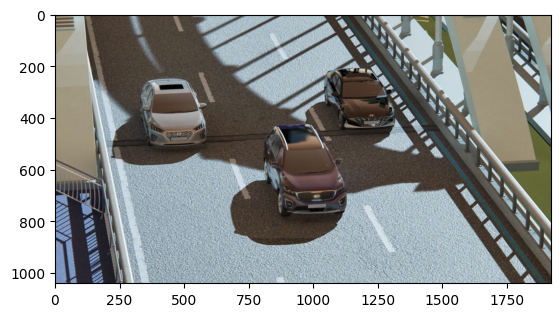

In [56]:
# 원본 이미지 확인
image_path = '/content/data/test/syn_00000_1.png'
image = cv2.imread(image_path)

plt.imshow(image)

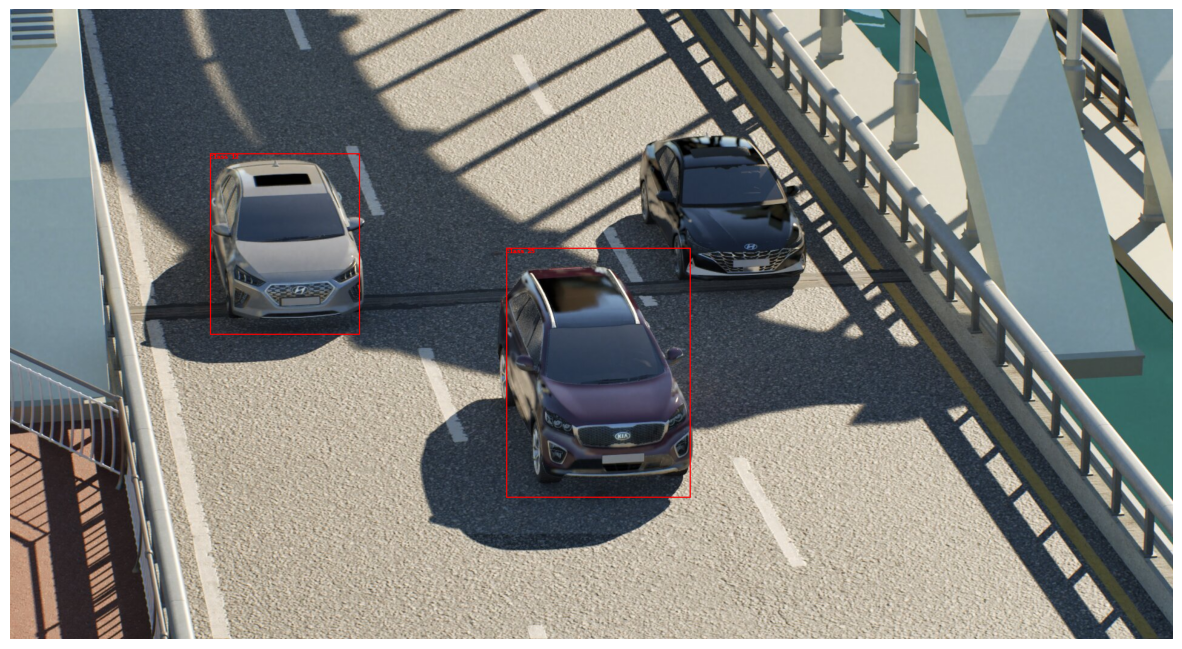

In [67]:
from PIL import Image, ImageDraw
import glob

# 이미지 경로와 .txt 파일 경로
image_paths = glob.glob("/content/data/test/syn_00000_1.png")
txt_paths = glob.glob("/content/trained_model/predict/labels/syn_00000_1.txt")

for image_path, txt_path in zip(image_paths, txt_paths):
    img = Image.open(image_path)
    img_draw = ImageDraw.Draw(img)

    with open(txt_path, 'r') as txt_file:
        lines = txt_file.readlines()

        for line in lines:
            class_id, x_center, y_center, width, height, confidence = map(float, line.strip().split())
            class_id = int(class_id)

            x1 = int((x_center - width / 2) * img.width)
            y1 = int((y_center - height / 2) * img.height)
            x2 = int((x_center + width / 2) * img.width)
            y2 = int((y_center + height / 2) * img.height)

            class_name = f"Class {class_id}"
            img_draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            img_draw.text((x1, y1), class_name, fill="red")

    # 디텍션 결과가 표시된 이미지 출력
    plt.figure(figsize = (15, 15))
    plt.axis('off')
    plt.imshow(img)

In [59]:
with open(txt_path, 'r') as txt_file:
  lines = txt_file.readlines()

lines

['12 0.759128 0.538528 0.148934 0.287457 0.727301\n',
 '25 0.753167 0.527522 0.143754 0.309606 0.613346\n']

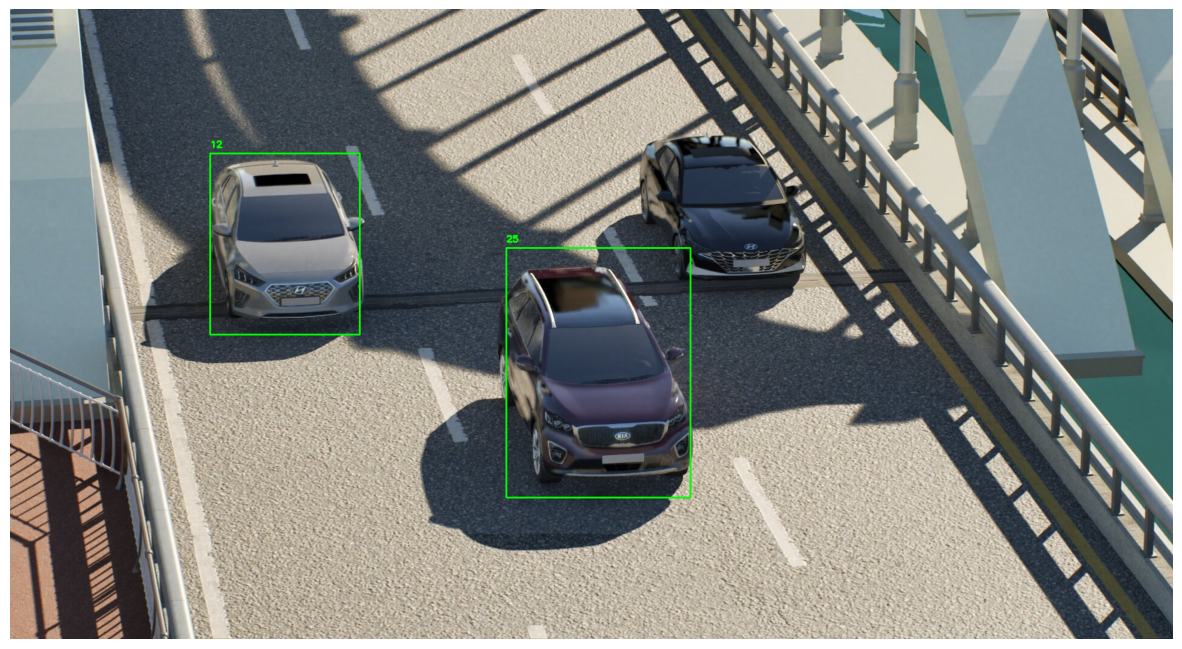

In [65]:
import cv2
import matplotlib.pyplot as plt

image_path = '/content/data/test/syn_00000_1.png'
image = cv2.imread(image_path)

with open(txt_path, 'r') as txt_file:
    lines = txt_file.readlines()

for line in lines:
    class_id, x_center, y_center, width, height, confidence = map(float, line.strip().split())
    class_id = int(class_id)

    x1 = int((x_center - width / 2) * image.shape[1])  # 이미지의 너비
    y1 = int((y_center - height / 2) * image.shape[0])  # 이미지의 높이
    x2 = int((x_center + width / 2) * image.shape[1])
    y2 = int((y_center + height / 2) * image.shape[0])

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, str(class_id), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Show the annotated image
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()